## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

# Papers

* [GAN](https://arxiv.org/pdf/1406.2661.pdf)
* [Pix2pix](https://arxiv.org/pdf/1611.07004.pdf)
* [Cycle-GAN](https://arxiv.org/pdf/1703.10593.pdf)


# pix2pix

## Задача

Генерация изображения по границам.

* Повторить генерацию обуви по границам по по готовому датасету
    
    Сделал edges2shoes. Сам датасет довольно большой. Удалось только 2 эпохи провести на всем датасете. И в сгенеренной обуви начали появляться тени, границы, но цвет везде коричневый. Но если обучиться на маленькой части (и сделть больше эпох), то работает неплохо (на трейне))).

* Сделать генерацию чего-то своего, подготовить датасет

    Попробовал собрать датасет смешариков. 60 изображений для восьми смешариков.
    Границы рисовал с помощью [Canny edge detection](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html) в этой [тетрадке](https://github.com/mrsndmn/edges2smeshariki/blob/master/smeshariki/Untitled.ipynb) + ручная работа. Еще есть тестовые примеры, часть взял из раскрасок. Часть нарисовал сам. Считаю, что самодельная Нюша самая замечательная.

## Картинка для превлечения внимания

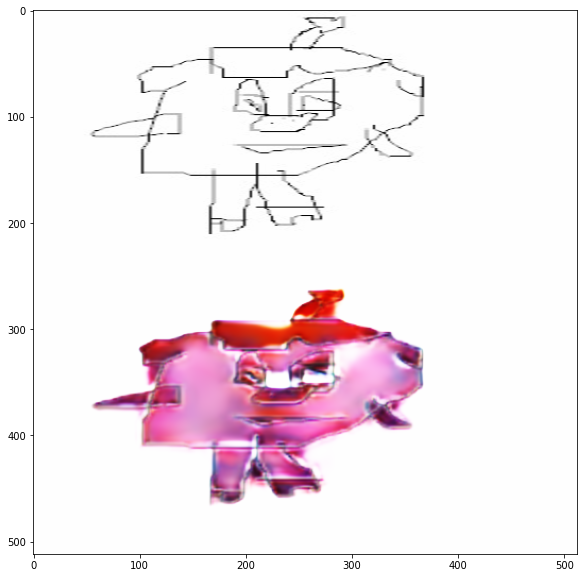

# Код

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/edges2shoes.tar.gz
# ! cp edges2shoes.tar.gz '/content/drive/MyDrive/Colab Notebooks/data/'

In [ ]:
! cp '/content/drive/MyDrive/Colab Notebooks/data/edges2shoes.tar.gz' ./
! tar -xf edges2shoes.tar.gz

In [1]:
! pip install pytorch-lightning --quiet

     |████████████████████████████████| 686kB 8.1MB/s 
     |████████████████████████████████| 276kB 13.7MB/s 
     |████████████████████████████████| 829kB 21.0MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 1.3MB 27.5MB/s 
     |████████████████████████████████| 143kB 57.1MB/s 
     |████████████████████████████████| 296kB 52.8MB/s 


In [2]:
import torch
import torch.nn as nn
import os
import torch.nn.functional as F

import pytorch_lightning as pl

import matplotlib.pyplot as plt
import cv2
from collections import OrderedDict

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder

from typing import Any, Callable, cast, Dict, List, Optional, Tuple
import torchvision.datasets.folder as tvisdsfolder
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
class ShoesDataset(datasets.VisionDataset):
  def __init__(self, images_dir, transform: Optional[Callable] = None):
    self.loader = tvisdsfolder.default_loader
    self.transform = transform
    self.samples = sorted([ os.path.join(images_dir, d.name) for d in os.scandir(images_dir) ])

  def __getitem__(self, index: int):
    sample = self.loader( self.samples[index] )
    if self.transform is not None:
      sample = self.transform(sample)
    return sample

  def __len__(self):
    return len(self.samples)

class ShoesDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = '/content/edges2shoes', batch_size: int = 64, val_batch_size = None, num_workers: int = 4, train_size: float = 0.8) -> None:
        super().__init__()
        self.data_dir = data_dir
        self.train_dir = os.path.join(self.data_dir, 'train')
        self.test_dir = os.path.join(self.data_dir, 'val')

        self.train_size = train_size

        self.batch_size = batch_size
        self.val_batch_size = batch_size if val_batch_size is None else val_batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        return

    def prepare_data(self):
        return

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            e2shoes_full = ShoesDataset(self.train_dir, transform=self.transform)
            shoes_train_size = int(len(e2shoes_full) * ( self.train_size ))
            self.shoes_train, self.shoes_val = random_split(e2shoes_full, [shoes_train_size, len(e2shoes_full) - shoes_train_size])

        if stage == 'test' or stage is None:
            self.shoes_test = ShoesDataset(self.test_dir, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.shoes_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.shoes_val, batch_size=self.val_batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.shoes_test, batch_size=self.batch_size, num_workers=self.num_workers)

tensor(-1.) tensor(1.)


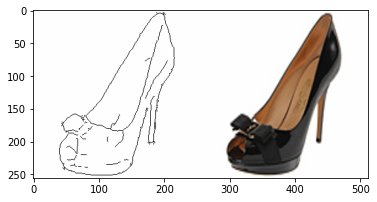

In [ ]:
torch.manual_seed(0)
sdm = ShoesDataModule(batch_size=1, num_workers=0)
sdm.setup()
img_test = next(iter(sdm.train_dataloader())).permute(0, 2, 3, 1)
print(img_test.min(), img_test.max())
plt.imshow(torchvision.utils.make_grid( img_test, normalize=True, range=(-1,1) ))

In [4]:
# это где-то спер, но уже не знаю, где
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Discriminator(nn.Module):
  def __init__(self, image_shape: Tuple[int, int]) -> None:
    super().__init__()

    # модель для самого изображения
    self.img_model = nn.Sequential(
      nn.Conv2d(6, 64, kernel_size=3, padding=1), # image_shape
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool2d(kernel_size=2), # image_shape / 2
      nn.Conv2d(64, 128, kernel_size=3, padding=1), # image_shape
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool2d(kernel_size=2), # image_shape / 4
      nn.Conv2d(128, 256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool2d(kernel_size=2), # image_shape / 8
      nn.Conv2d(256, 512, kernel_size=3, padding=1),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool2d(kernel_size=2), # image_shape / 16
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool2d(kernel_size=2), # image_shape / 32
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool2d(kernel_size=2), # image_shape / 64
    )

    out_features_in = int(image_shape[0] / 64 * image_shape[1] / 64)  * 512 # 512: num_out_conv_features, 2: image, condition
    
    self.out = nn.Sequential(
      nn.Linear(out_features_in, 1),
    #   nn.Sigmoid(),
    #   nn.Softmax(dim=1),
    )
  
  def forward(self, cond_img):

      image_features = self.img_model(cond_img)

      return self.out(image_features.reshape(image_features.shape[0], -1))

In [6]:
class Generator(nn.Module):
  def __init__(self, image_shape: Tuple[int, int]) -> None:
    super().__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.2, inplace=True),
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, inplace=True),
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # image_shape
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),
    )

    self.conv4 = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), # image_shape
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),
    )

    self.conv5 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False), # image_shape
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),
    )

    self.conv6 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False), # image_shape
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),
    )
    
    # из чатика про cycly-gan'ы в слаке
    # https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/190#issuecomment-358546675
    self.tconv6 = nn.Sequential(
      nn.Upsample(scale_factor=4, mode='bilinear'),
      nn.ReflectionPad2d(1),
      nn.Conv2d(512, 512, kernel_size=4, stride=2, bias=False),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
    )
    self.tconv5 = nn.Sequential(
      nn.Upsample(scale_factor=4, mode='bilinear'),
      nn.ReflectionPad2d(1),
      nn.Conv2d(1024, 512, kernel_size=4, stride=2, bias=False),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
    )

    self.tconv4 = nn.Sequential(
      nn.Upsample(scale_factor=4, mode='bilinear'),
      nn.ReflectionPad2d(1),
      nn.Conv2d(1024, 256, kernel_size=4, stride=2, bias=False),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
    )

    self.tconv3 = nn.Sequential(
      nn.Upsample(scale_factor=4, mode='bilinear'),
      nn.ReflectionPad2d(1),
      nn.Conv2d(512, 128, kernel_size=4, stride=2, bias=False),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
    )

    self.tconv2 = nn.Sequential(
      nn.Upsample(scale_factor=4, mode='bilinear'),
      nn.ReflectionPad2d(1),
      nn.Conv2d(256, 64, kernel_size=4, stride=2, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
    )

    self.tconv1 = nn.Sequential(
      nn.Upsample(scale_factor=4, mode='bilinear'),
      nn.ReflectionPad2d(1),
      nn.Conv2d(128, 3, kernel_size=4, stride=2, bias=False),
      nn.Tanh(),
    )

    return

  def forward(self, edges):

    conv1_features = self.conv1(edges)
    conv2_features = self.conv2(conv1_features)
    conv3_features = self.conv3(conv2_features)
    conv4_features = self.conv4(conv3_features)
    conv5_features = self.conv5(conv4_features)
    conv6_features = self.conv6(conv5_features)

    tconv6_features = self.tconv6(conv6_features)
    tconv5_features = self.tconv5( torch.cat((tconv6_features, conv5_features), dim=1) )
    tconv4_features = self.tconv4( torch.cat((tconv5_features, conv4_features), dim=1) )
    tconv3_features = self.tconv3( torch.cat((tconv4_features, conv3_features), dim=1) )
    tconv2_features = self.tconv2( torch.cat((tconv3_features, conv2_features), dim=1) )
    tconv1_features = self.tconv1( torch.cat((tconv2_features, conv1_features), dim=1) )
    return tconv1_features


In [7]:
class Pix2pix(pl.LightningModule):
    def __init__(
        self,
        glr = 0.0002,
        dlr = 0.0002,
        b1 = 0.5,
        b2 = 0.999,
        l1lambda=100,
        generator=None,
        discriminator = None,
        init_g_weights = True,
        init_d_weights = True
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        self.data_shape = ( 256, 256, )
        self.generator = generator if generator is not None else Generator(self.data_shape)
        self.discriminator = discriminator if discriminator is not None else Discriminator(self.data_shape)
        if init_g_weights:
            self.generator.apply(weights_init)
        if init_d_weights:
            self.discriminator.apply(weights_init)

        self.train_img_idx = 0

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)

    def freeze_generator(self):
        for p in self.generator.parameters():
            p.requires_grad = False

    def freeze_discriminator(self):
        for p in self.discriminator.parameters():
            p.requires_grad = False

    def unfreeze_generator(self):
        for p in self.generator.parameters():
            p.requires_grad = True

    def unfreeze_discriminator(self):
        for p in self.discriminator.parameters():
            p.requires_grad = True

    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs = batch

        edges = imgs[:, :, :, :256]
        real_shoes = imgs[:, :, :, 256:]

        # train generator
        if optimizer_idx == 0:

            self.freeze_discriminator()
            self.unfreeze_generator()


            # generate images
            generated_imgs = self.generator(edges)

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(imgs.size(0), 1).to(imgs.device)
            valid = valid.type_as(imgs)

            # adversarial loss is binary cross-entropy
            g_loss_adv = self.adversarial_loss(self.discriminator(torch.cat((edges, generated_imgs), dim=1)), valid)
            # g_loss_adv = 0
            self.log('g_loss_adv', g_loss_adv.clone().detach(), prog_bar=True)

            g_loss_f1 = F.l1_loss(generated_imgs, real_shoes) * self.hparams.l1lambda
            g_loss = g_loss_f1 + g_loss_adv

            self.log('loss', g_loss)
            self.log('g_loss', g_loss.clone().detach())
            self.log('g_loss_f1', g_loss_f1.clone().detach(), prog_bar=True)

            if batch_idx % 1000 == 0:
                grid = torchvision.utils.make_grid(torch.cat((generated_imgs, real_shoes), dim=2), normalize=True, range=(-1, 1))
                self.logger.experiment.add_image('train_generated_images', grid, self.train_img_idx)
                self.train_img_idx += 1

            return g_loss

        # train discriminator
        if optimizer_idx == 1:
            self.freeze_generator()
            self.unfreeze_discriminator()

            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(imgs.size(0), 1)
            fake = torch.zeros(imgs.size(0), 1)
            targets = torch.cat((valid, fake), dim=0)
            targets = targets.to(imgs.device)

            edges_doubled = edges.repeat(2, 1, 1, 1)

            generated_shoes = self.generator(edges)
            real_and_generated_shoes = torch.cat((real_shoes, generated_shoes.detach()), dim=0)
            desc_outputs = self.discriminator(torch.cat((edges_doubled, real_and_generated_shoes), dim=1))
            
            # print(desc_outputs[:4, :], targets[:4, :])
            d_loss = self.adversarial_loss(desc_outputs, targets)

            d_loss_log = d_loss.clone().detach()
            self.log('loss', d_loss)
            self.log('d_loss', d_loss_log, prog_bar=True)
            return d_loss

    def test_step(self, batch, batch_idx):
        imgs = batch
        edges = imgs
        generated_imgs = self.generator(edges)

        grid = torchvision.utils.make_grid(torch.cat((generated_imgs, imgs), dim=2), normalize=True, range=(-1, 1))
        self.logger.experiment.add_image('test_generated_images', grid, batch_idx)

        return 42

    def validation_step(self, batch, batch_idx):
        imgs = batch

        edges = imgs[:, :, :, :256]
        real_shoes = imgs[:, :, :, 256:]

        generated_imgs = self.generator(edges)
        valid = torch.ones(imgs.size(0), 1).to(imgs.device)
        valid = valid.type_as(imgs)

        g_loss = self.adversarial_loss(self.discriminator(torch.cat((edges, generated_imgs), dim=1)), valid)
        g_loss += F.l1_loss(generated_imgs, real_shoes) * self.hparams.l1lambda
        g_loss_log = g_loss.clone().detach()

        self.log('val_loss', g_loss_log)

        if batch_idx == 0:
            grid = torchvision.utils.make_grid(torch.cat((generated_imgs, real_shoes), dim=2), normalize=True, range=(-1, 1))
            self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

        return g_loss

    def configure_optimizers(self):
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.hparams.glr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.hparams.dlr, betas=(b1, b2))
        return [opt_g, opt_d], []
        

In [ ]:
%%time

dm = ShoesDataModule(batch_size=1, val_batch_size=8, num_workers=0)
# p2p = Pix2pix(glr=2e-4, dlr=2e-4, b1 = 0.5, b2 = 0.999, l1lambda=100)
p2p = Pix2pix.load_from_checkpoint('/content/drive/MyDrive/Colab Notebooks/dls-p2p/checkpoints/' + 'shoes-egdes-100-shoes-epoch=19-g_loss=7.08.ckpt')

trainer = pl.Trainer(gpus=1, max_epochs=100, deterministic=True, progress_bar_refresh_rate=20, limit_train_batches=100, limit_val_batches=1)
trainer.fit(p2p, dm)

# trainer.save_checkpoint() # '/content/drive/MyDrive/Colab Notebooks/dls-p2p/checkpoints/')

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Не очень удачные варианты

### SiLU + TransposedConv

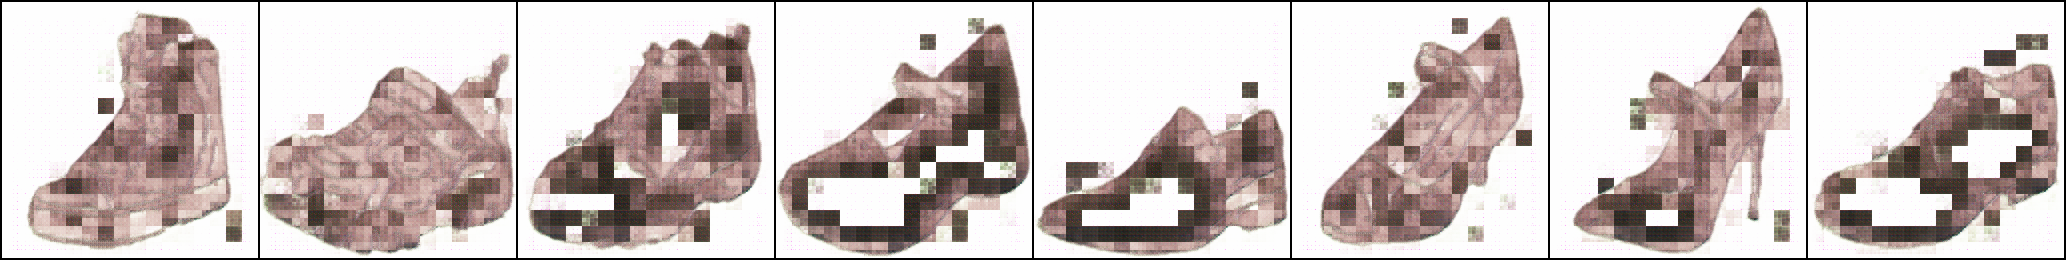

### LeakyReLU + ReLU + Bilinear Upsampling

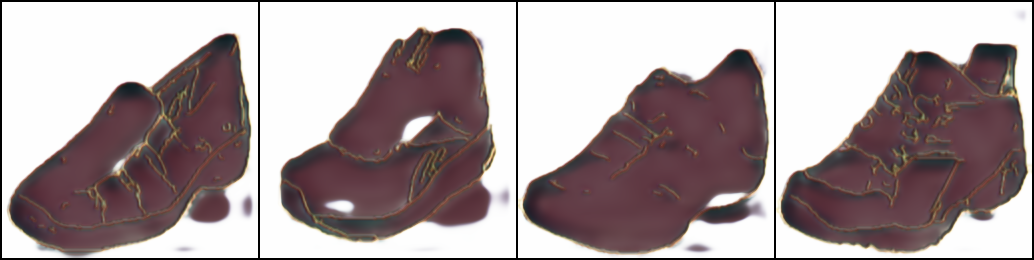

### ReLU + Bilinear Upsampling

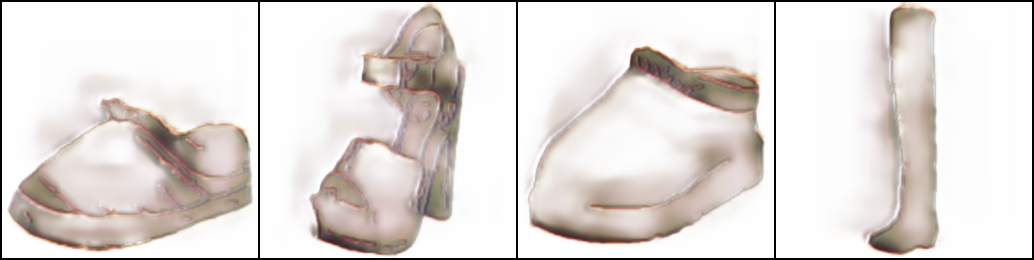

### Только генератор обучался, только f1-loss

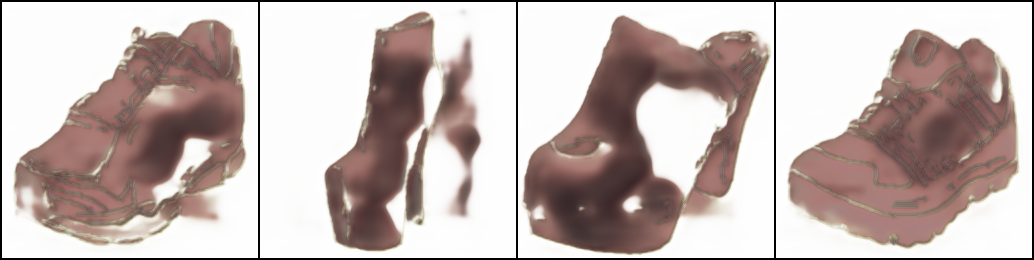

## shoes-egdes-full-dataset-epoch=01-g_loss=21.51.ckpt

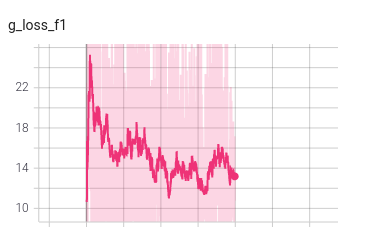

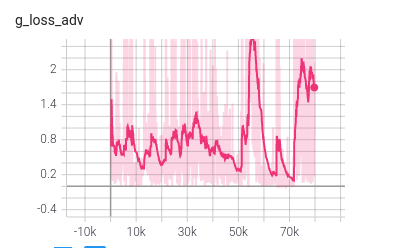

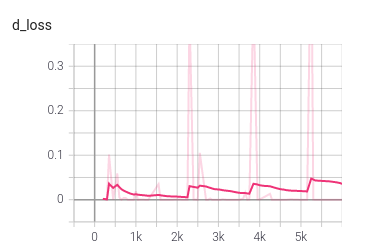

### Valid images

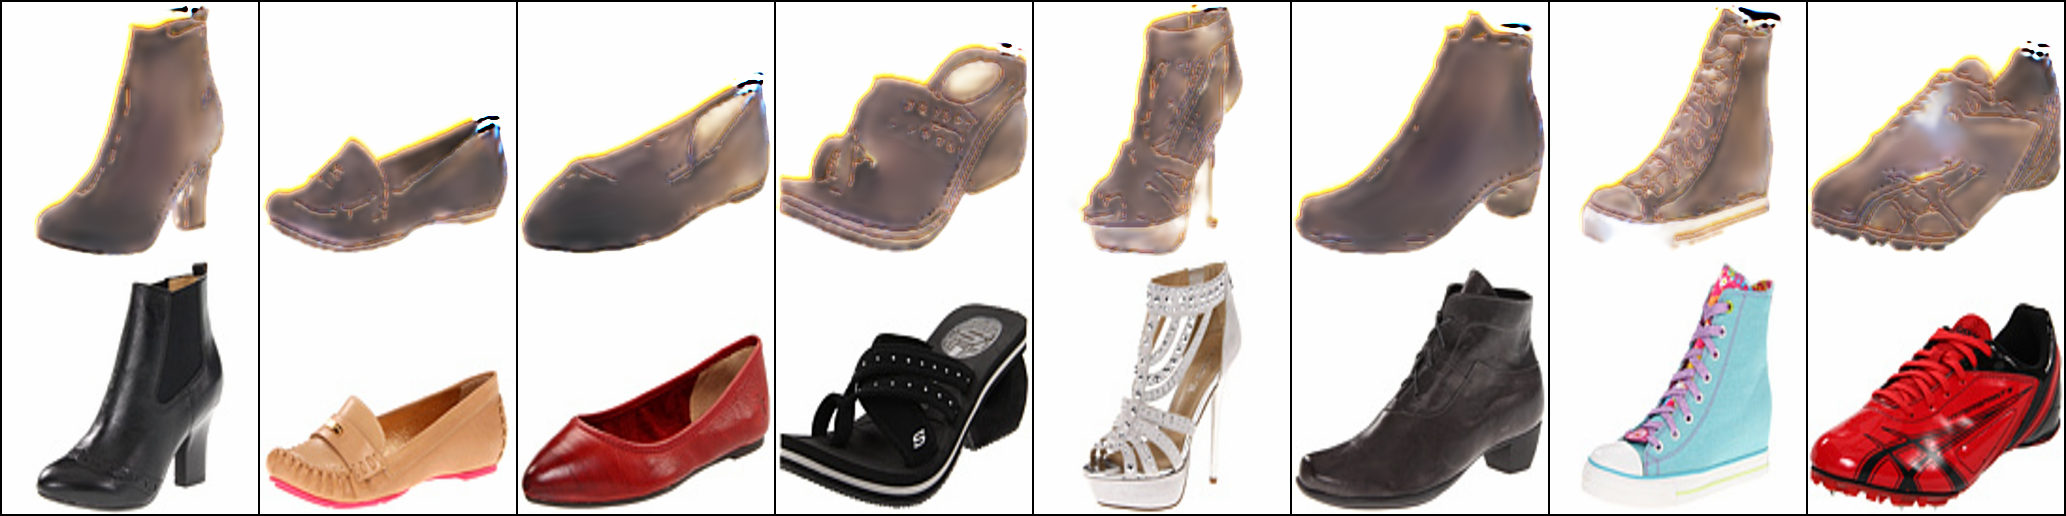

### Train images

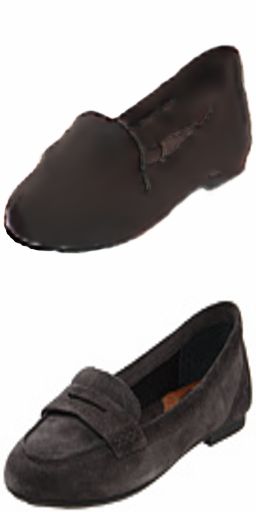

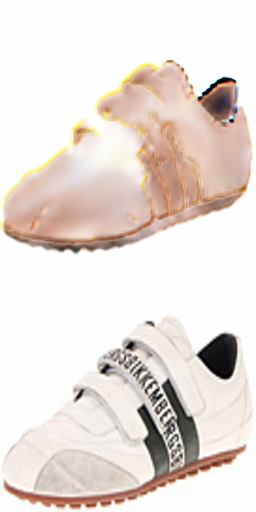

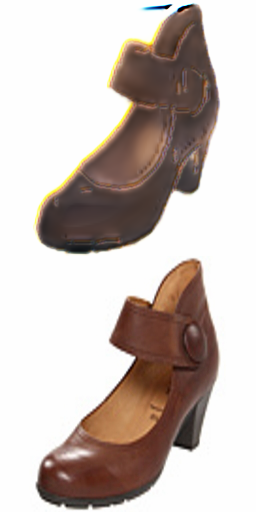

## shoes-egdes-100-shoes

Так как на всем датасете было бы очень долго обучаться, решил попробовать просто хотябы переобучиться на 100 парах обуви. Это получилось и на валидационной выборке видно, что текстуры с первого ботинка попадают и на валидационные ботинки.

In [ ]:
gener = p2p.generator
gener = gener.eval()
gener.to('cuda')

with torch.no_grad():
    generated_imgs = []
    for i, batch in enumerate(p2p.train_dataloader()):
        if i > 15:
            break

        batch_edges = batch[:, :, :, :256].to('cuda')
        batch_img_real = batch[:, :, :, 256:]
        img = gener(batch_edges)
        generated_imgs.append(torch.cat((batch_img_real, img.detach().cpu()), dim=2))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


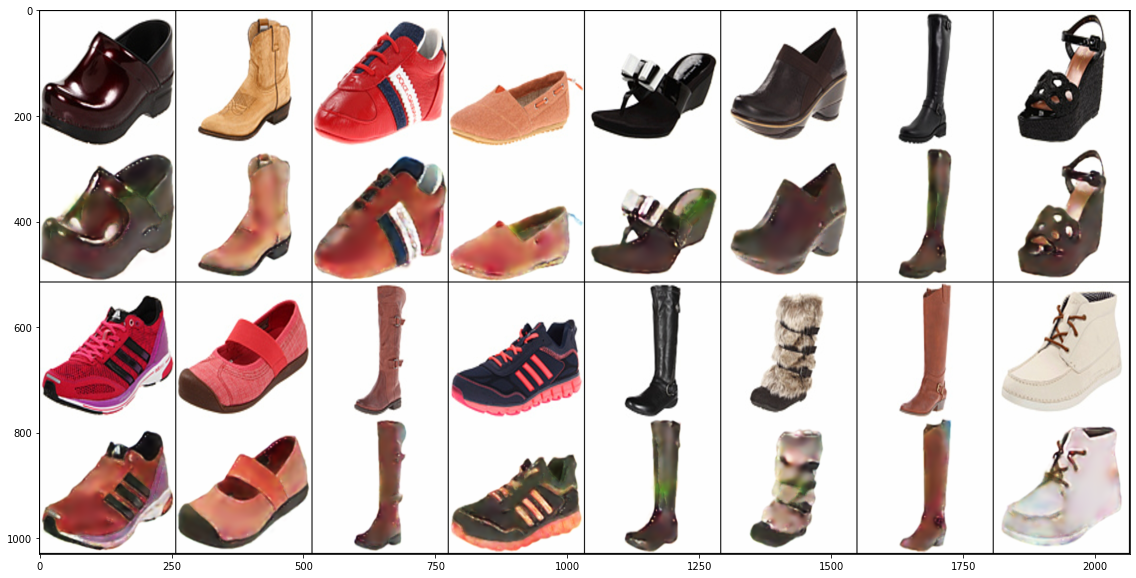

In [ ]:
trained_grid = torchvision.utils.make_grid(torch.cat(generated_imgs, dim=0).detach().cpu() , normalize=True, range=(-1, 1))

plt.gcf().set_size_inches(20, 10)
plt.imshow(trained_grid.permute(1, 2, 0))

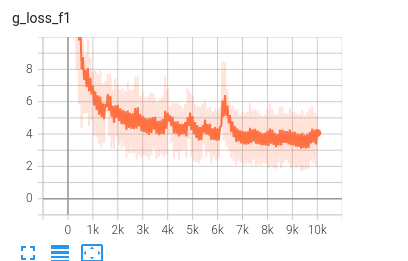

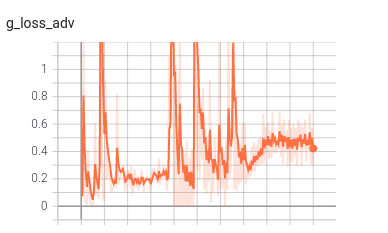

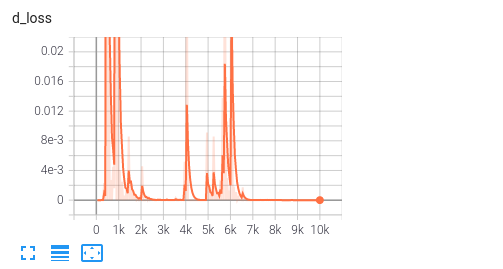

# Своя задача

Сделаю границы в смешариков.

Сам собрал, накачал и привел к jpg картинки разных смешариков.

In [64]:
# !rm -rf ./smeshariki_test.zip ./smeshariki_test
!unzip -q ./smeshariki_test.zip

In [12]:
!unzip -q ./smeshariki.zip

In [65]:
import torchvision.transforms.functional as tvtrnsfmsfunc
import numpy as np
from PIL import Image

In [71]:
class SmesharikiDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = '/content/smeshariki', test_dir= '/content/smeshariki_test', batch_size: int = 64, val_batch_size = None, num_workers: int = 4) -> None:
        super().__init__()
        self.data_dir = data_dir
        self.test_dir = test_dir

        self.batch_size = batch_size
        self.num_workers = num_workers

        self.rafine = transforms.RandomAffine((-10,10))
        self.resizer = transforms.Resize((256, 512))

        self.train_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        self.test_transform = transforms.Compose([
            self.resizer,
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        return

    def prepare_data(self):
        return
    
    def get_concat_h(self, im1, im2):
        dst = Image.new('RGB', (im1.width + im2.width, im1.height))
        dst.paste(im1, (0, 0))
        dst.paste(im2, (im1.width, 0))
        return dst

    def train_transform(self, sample):
        # edge = sample
        sample = self.resizer(sample)
        # print(sample)
        orig_sample_edges = sample.crop((0, 0, 256, 256))
        orig_sample_image = sample.crop((256, 0, 512, 256))
        
        img_size = tvtrnsfmsfunc._get_image_size(orig_sample_image)
        scale_ranges, shears = (0.8, 1.2), None
        degrees, translate = (-40, 40,), (0.1, 0.1,)

        # angle, translations, scale, shear
        affine_params = self.rafine.get_params(degrees=degrees, translate=translate, scale_ranges=scale_ranges, shears=shears, img_size=img_size)
        # print("angle, translations, scale, shear")
        # print(affine_params)
        
        sample_image = tvtrnsfmsfunc.affine(orig_sample_image, *affine_params, resample=2, fillcolor=(255,255,255))
        sample_edges = tvtrnsfmsfunc.affine(orig_sample_edges, *affine_params, resample=2, fillcolor=(255,255,255))

        sample_cat = self.get_concat_h(sample_edges, sample_image)
        # sample_cat = self.get_concat_h(orig_sample_edges, orig_sample_image)
        sample_transformed = self.train_transforms(sample_cat)
        return sample_transformed

    def setup(self, stage=None):
        self.smeshariki_train = torchvision.datasets.DatasetFolder(self.data_dir, loader=tvisdsfolder.default_loader, transform=self.train_transform, extensions="jpg")
        self.smeshariki_test = torchvision.datasets.DatasetFolder(self.test_dir, loader=tvisdsfolder.default_loader, transform=self.test_transform, extensions="jpg")
        return

    def train_dataloader(self):
        return DataLoader(self.smeshariki_train, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=self.collate)

    def val_dataloader(self):
        return DataLoader(self.smeshariki_test, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=self.collate)

    def test_dataloader(self):
        return DataLoader(self.smeshariki_test, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=self.collate)

    def collate(self, batch):
        batch = [ tup[0].unsqueeze(0) for tup in batch]
        res = torch.cat(batch, dim=0)
        return res


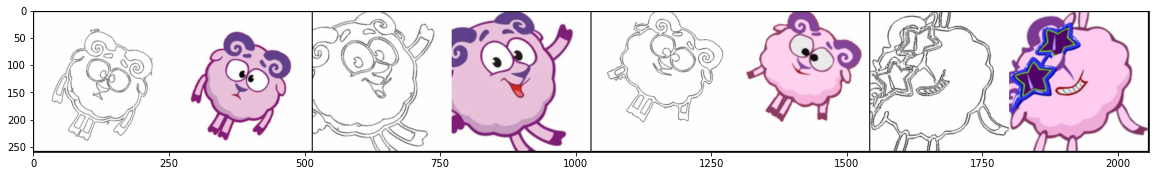

In [40]:
sdm = SmesharikiDataModule(batch_size=4, num_workers=0)
sdm.setup('fit')
img_test = next(iter(sdm.train_dataloader()))

transformed_grid = torchvision.utils.make_grid(img_test, normalize=True, range=(-1, 1))

plt.gcf().set_size_inches(20, 20)
plt.imshow(transformed_grid.permute(1, 2, 0))

In [76]:
class SmesharikiPix2pix(Pix2pix):

    def validation_step(self, batch, batch_idx):
        imgs = batch

        edges = imgs
        generated_imgs = self.generator(edges)

        grid = torchvision.utils.make_grid(torch.cat((generated_imgs, edges), dim=2), normalize=True, range=(-1, 1))
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch * 1000 + batch_idx)

        return

In [79]:
# Start tensorboard.
%%time

smesharikidm = SmesharikiDataModule(batch_size=4, num_workers=0)
# smeshariki_p2p = Pix2pix(glr=15e-4, dlr=2e-4, b1 = 0.5, b2 = 0.999, l1lambda=100)
smeshariki_p2p = SmesharikiPix2pix.load_from_checkpoint('/content/drive/MyDrive/Colab Notebooks/dls-p2p/checkpoints/smeshariki_300e.chkpt')

trainer = pl.Trainer(gpus=1, max_epochs=2, deterministic=True, progress_bar_refresh_rate=20, limit_val_batches=1)
# trainer.fit(smeshariki_p2p, smesharikidm)

# trainer.save_checkpoint('/content/drive/MyDrive/Colab Notebooks/dls-p2p/checkpoints/smeshariki_900e.chkpt') # '/content/drive/MyDrive/Colab Notebooks/dls-p2p/checkpoints/')

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CPU times: user 592 ms, sys: 245 ms, total: 837 ms
Wall time: 1.1 s


In [61]:
smesharikidm.setup(None)
trainer.test(smeshariki_p2p, test_dataloaders=smesharikidm.test_dataloader())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

In [33]:
# !rm -rf lightning_logs/

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


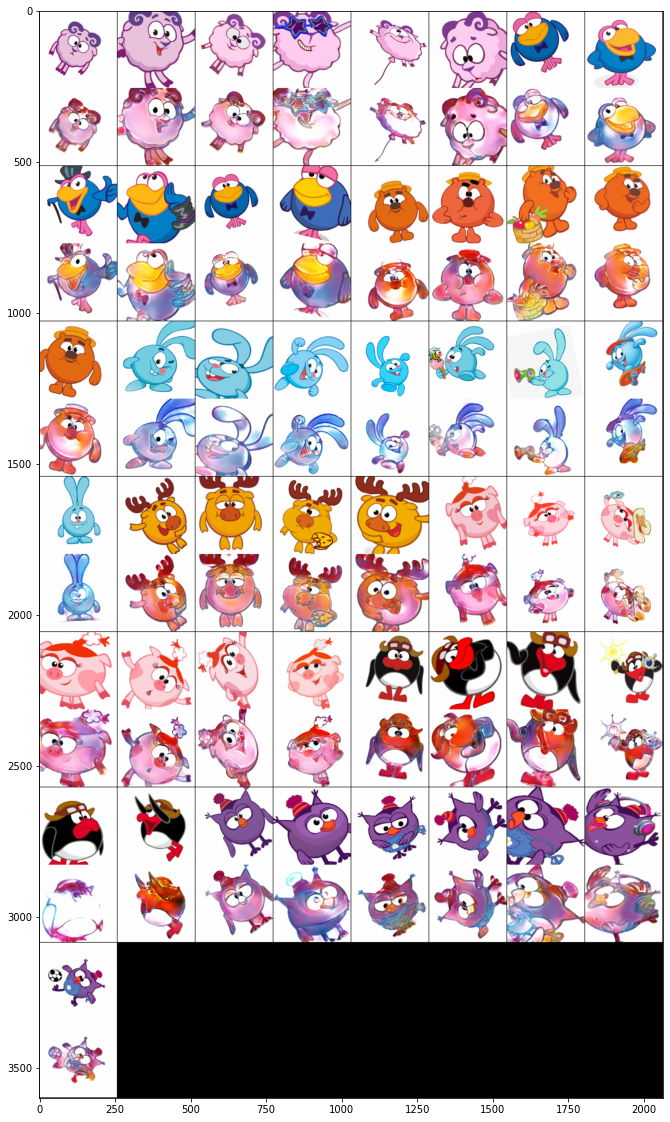

In [50]:
gener = smeshariki_p2p.generator
gener = gener.eval()
gener.to('cuda')

with torch.no_grad():
    generated_imgs = []
    for i, batch in enumerate(smeshariki_p2p.train_dataloader()):
        if i > 15:
            break

        batch_edges = batch[:, :, :, :256].to('cuda')
        batch_img_real = batch[:, :, :, 256:]
        img = gener(batch_edges)
        generated_imgs.append(torch.cat((batch_img_real, img.detach().cpu()), dim=2))

trained_grid = torchvision.utils.make_grid(torch.cat(generated_imgs, dim=0).detach().cpu() , normalize=True, range=(-1, 1))

plt.gcf().set_size_inches(20, 20)
plt.imshow(trained_grid.permute(1, 2, 0))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


2


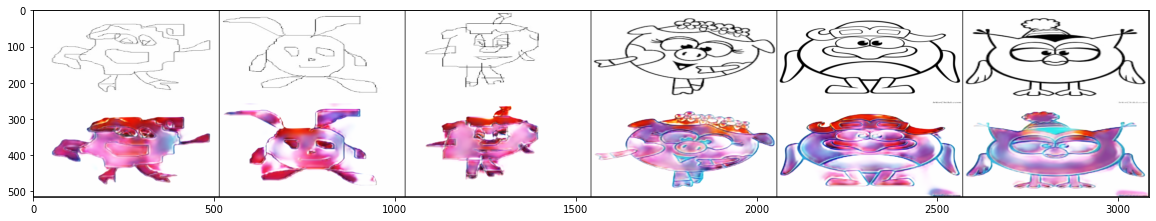

In [87]:
gener = smeshariki_p2p.generator
gener = gener.eval()
gener.to('cuda')

with torch.no_grad():
    generated_imgs = []
    smesharikidm.setup(None)
    for i, batch in enumerate(smesharikidm.test_dataloader()):
        if i > 15:
            break

        batch_edges = batch[:, :, :].to('cuda')
        # batch_img_real = batch[:, :, :, 256:]
        img = gener(batch_edges)
        generated_imgs.append(torch.cat((batch_edges.to('cpu'), img.detach().cpu()), dim=2))

    print(len(generated_imgs))
    trained_grid = torchvision.utils.make_grid(torch.cat(generated_imgs, dim=0).detach().cpu() , normalize=True, range=(-1, 1))

    plt.gcf().set_size_inches(20, 20)
    plt.imshow(trained_grid.permute(1, 2, 0))